## CRISP-DM (https://www.datascience-pm.com/crisp-dm-2/)

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation
- 6. Deployment

### 2. Data Understanding

In [186]:
import csv
import random
import warnings
import numpy as np
import time as time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def read_and_truncate_dataset(file_path_1="dataset.csv", file_path_2="./FinalProject/dataset.csv", percentagem_da_dataset_a_usar=3):
    """
    Retorna um numpy array de arrays com o dataset da mesma forma que está no csv. Retorna também um panda dataframe

    Controla a quantidade de dados a usar da dataset original com percentagem_da_dataset_a_usar. 3.24 ~= 10000 linhas do csv original
    """
    try:
        with open(file_path_1, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_1)
    except FileNotFoundError:
        with open(file_path_2, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_2)
    
    # Truncate dataset
    num_rows_to_use = int(len(dadosC) * (percentagem_da_dataset_a_usar / 100))
    truncated_dadosC = dadosC.head(num_rows_to_use)

    # Convert to NumPy array
    numpy_array = truncated_dadosC.to_numpy()

    # Return both NumPy array, Pandas DataFrame, and column names
    return numpy_array, truncated_dadosC, categorias

numpy_arrays_dataset, pandas_frame_dataset, categorias = read_and_truncate_dataset(percentagem_da_dataset_a_usar=3) # para testes e desenvolvimento

numpy_arrays_dataset_transposed = numpy_arrays_dataset.T

In [187]:
def exemplos_dataset():
	"""
	Mostra como o dataset está formatado
	"""
	# exemplos do dataset
	for i in range(len(categorias)):
		print("Categoria "+str(categorias[i])+":")
		print(numpy_arrays_dataset_transposed[i,0:5],end="\n\n")

def graficos_gerais(categorias=categorias):
	"""
	Devolve graficos para visualisar melhor o dataset

	Devolve os graficos de todos as categorias por default mas pode escolher uma cagetoria em especifico para mostrar

	graficos_gerais(['Exercise','Checkup'])
	graficos_gerais()
	"""
	print("categorias escolhidas: "+str(categorias))
	for i in categorias:
		contar = Counter(pandas_frame_dataset.T.loc[i])

		print(i,end=":\n")
		print("Respostas possiveis: "+str(sorted(contar.keys())))
		print("Ocorrencia dessas respostas: "+str(contar.values()))

		plt.title("Respostas sobre a categoria "+str(i))
		plt.pie(contar.values(),labels=contar.keys(),autopct='%1.1f%%')
		plt.show()


def inconsistencias():
	"""
	Mostra algumas consisntecias e inconsistencias nos dados
	"""
	# mostrar que nao tem valores em falta
	print("tamanho de cada categoria",end=": ")
	for i in numpy_arrays_dataset_transposed:
		print(len(i),end=", ")
	print("\ntamanho do conjunto das respostas de cada pessoa"+str(len(numpy_arrays_dataset)))

	print("\nIrrelevâncias em algumas categorias:")
	for i in ['Height_(cm)', 'Weight_(kg)', 'BMI','Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']:
		contar = Counter(pandas_frame_dataset.T.loc[i])

		plt.title("Respostas sobre a categoria "+str(i))
		plt.pie(contar.values(),labels=contar.keys(),autopct='%1.1f%%')
		plt.show()

#exemplos_dataset()
#graficos_gerais()
#inconsistencias()

### 3. Data Preparation

#### Strategies to handle missing values

In [188]:
def damage_dataset(percentage, dataset):
	"""
    Remove x percentagem dos dados do dataset
	"""
	dataset = dataset.to_numpy()
	tamanho = dataset.size

	for i in range(int(tamanho*percentage)):
		dataset[random.randint(0,len(dataset)-1)][random.randint(0,len(dataset[0])-1)] = None # elemento random mete para None

	return pd.DataFrame(dataset)


In [189]:
def troca_pelo_mais_frequente(dataset):
	"""  
	Pega no dataset com Nones e substitui-os pelo valor mais frequente da categoria
	"""
	dataset = dataset.to_numpy()
	dataset = dataset.T

	# guarda o elemtno mais frequente de todas as categorias
	mais_frequente = []
	for i in range(len(dataset)):
		conta = Counter(dataset[i])
		del conta[None]
		mais_frequente.append(conta.most_common(1))

	# substitiu tocas as ocorrencias de None pelo mais frequente da categoria
	for i in range(len(dataset)):
		for j in range(len(dataset[i])):
			if dataset[i][j] == None:
				dataset[i][j] = mais_frequente[i][0][0]

	return pd.DataFrame(dataset.T)

def remove_lines_with_missing_values(dataset):
    if isinstance(dataset, np.ndarray):
        dataset = pd.DataFrame(dataset)
    elif not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset must be either a pandas DataFrame or a NumPy array.")

    initial_rows = len(dataset)
    cleaned_dataset = dataset.dropna()
    final_rows = len(cleaned_dataset)
    removed_percentage = ((initial_rows - final_rows) / initial_rows) * 100

    print(f"[REMOVE_LINES_WITH_MISSING_VALUES]: Percentage of rows removed: {removed_percentage:.2f}%")
    return cleaned_dataset

def fill_missing_values_with_mean_and_mode(dataset):
    """
    Usa a média para preencher valores númericos em falta
    Usa a moda para preencher valores categoricos em falta
    """
    if isinstance(dataset, np.ndarray):
        dataset = pd.DataFrame(dataset)
    elif not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset must be either a pandas DataFrame or a NumPy array.")

    for column in dataset.columns:
        if dataset[column].dtype in ['float64', 'int64']:  # valores numericos
            mean_value = dataset[column].mean()
            dataset[column].fillna(mean_value, inplace=True)
        else:  # valores categoricos
            mode_value = dataset[column].mode()[0]
            dataset[column].fillna(mode_value, inplace=True)

    return dataset

In [190]:
damaged_dataset = damage_dataset(0.2,pandas_frame_dataset.copy()) # Substitui 20% dos datapoints por None

# Method 0 (Jonnas)
removed_lines_with_missing_values_dataset = remove_lines_with_missing_values(damaged_dataset.copy())

# Method 1 (Vicente) 
mais_freq = troca_pelo_mais_frequente(damaged_dataset.copy())

# Method 2 (Jonnas)
mean_and_mode_missing_values_dataset = fill_missing_values_with_mean_and_mode(damaged_dataset.copy()) # em valores categoricos usa a moda, em numericos usa o mean

print('damage_dataset')
print(damaged_dataset)
print('Metodo 0: removed_lines_with_missing_values_dataset')
print(removed_lines_with_missing_values_dataset)
print("Metodo 1: troca_pelo_mais_frequente")
print(mais_freq)
print('Metodo 2: mean_and_mode_missing_values_dataset')
print(mean_and_mode_missing_values_dataset)

[REMOVE_LINES_WITH_MISSING_VALUES]: Percentage of rows removed: 97.88%
damage_dataset
             0                        1     2     3     4     5     6     7   \
0          Poor  Within the past 2 years  None    No    No    No    No    No   
1     Very Good     Within the past year  None   Yes    No    No    No  None   
2     Very Good     Within the past year  None  None  None    No  None   Yes   
3          Poor                     None   Yes   Yes    No    No  None   Yes   
4          None     Within the past year    No    No    No  None    No    No   
...         ...                      ...   ...   ...   ...   ...   ...   ...   
9260  Very Good     Within the past year  None  None  None    No    No    No   
9261       Good     Within the past year   Yes   Yes   Yes    No    No  None   
9262  Excellent  Within the past 5 years   Yes    No    No    No    No    No   
9263  Very Good     Within the past year  None    No    No    No    No    No   
9264       Good      5 or more yea

#### Mudanças ao Dataset (Data reduction, Normalization, Discretization)

In [191]:
def preprocess_dataset(dataset, tipo=False, debug=False):
	"""
    Transforma todos os features não numericos num número com LabelEncoder, para os modelos scikit-learn poderem interpretar.

    Retorna uma matriz "features" com todos os dados menos os da da "Heart_Disease" e "target", apenas com a matriz "Heart_Disease" já codificada com a Label (portanto, com 0s e 1s em vez de Yes e No)
	"""

	# Como os modelos de machine learning do scikit-learn não conseguem lidar com dados categóricos, aqui codificamo-los em dados numéricos
	label_encoders = {}
	for column in dataset.select_dtypes(include=['object']).columns:
		encoder = LabelEncoder()
		dataset[column] = encoder.fit_transform(dataset[column].astype(str))
		label_encoders[column] = encoder
        # if debug, print the mapping 
		if debug:
			mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
			print(f"Encoding for '{column}': {mapping}")

    # matrix das features tem tudo menos a coluna "Heart_Disease", target tem apenas a coluna "Heart_Disease"
	features = dataset.drop(columns=["Heart_Disease"])
	target = dataset["Heart_Disease"]

	# retorna apenas o dataset
	if tipo==True:
		return dataset

	return features, target, label_encoders


def data_discretization(dataset, com_graficos):
	"""
	Aplica data discretization aos dadps para categorizar as categorias que mais precisam.
	Reduz a grande quantidade de labels de uma dada categoria para não termos que lidar com um excesso de labels.

	As categorias modificadas serão as seguintes: BMI, Altura, Peso, Consumo de fruta, Consumo de vegetais, 
												  Consumo de batatas fritas e Consumo de alcool

	São feitos graficos para mostrar os novos dados.
	"""
	
	if len(np.unique(dataset['BMI'])) == 5:
		print("Este dataset já foi discretizado")
		return dataset

	# Se o dataset já tiver side reduzido apenas faz a parte da discretization possivel
	if dataset.columns[-1] == "qualidade_da_dieta":

		print("Como o data reduction ja foi aplicado, apenas as colunas peso, altura e BMI serão alteradas")

		# passar o dataset para numpy para ser mais rapido na execuçao
		dataset = dataset.to_numpy()
		dataset = dataset.T

		#BMI -> calcular o BMI a partir do peso e altura e categoriza-lo com valores tabelados
		for i in range(len(dataset[11])):
			bmi = dataset[10][i]/((dataset[9][i]/100)**2)
			if bmi < 18.5:
				dataset[11][i] = "magra"
			elif bmi <= 24.9:
				dataset[11][i] = "normal"
			elif bmi <= 29.9:
				dataset[11][i] = "gorda"
			elif bmi <=34.9:
				dataset[11][i] = "obesidade ligeira"
			else:
				dataset[11][i] = "obesa"

		# ALTURA -> em vez de usar os valores verdadeiros da altura, reduzir para algumas categorias genericas
		for i in range(len(dataset[9])):
			if dataset[9][i] < 150: # +1.5m
				dataset[9][i] = "<150"
			elif dataset[9][i] >= 150 and dataset[9][i] <=160: # entre 1.5 e 1.6 m
				dataset[9][i] = "150-160"
			elif dataset[9][i] > 160 and dataset[9][i] <=170: # entre 1.6 e 1.7 m
				dataset[9][i] = "161-170"
			elif dataset[9][i] > 170 and dataset[9][i] <=180: # entre 1.7 e 1.8 m
				dataset[9][i] = "171-180"
			elif dataset[9][i] > 180 and dataset[9][i] <=190: # entre 1.8 e 1.9 m
				dataset[9][i] = "181-190"
			elif dataset[9][i] > 190 and dataset[9][i] <=200: # entre 1.9 e 2.0 m
				dataset[9][i] = "191-200"
			else: # +2.0m
				dataset[9][i] = ">200"
		
		# PESO -> em vez de usar os valores verdadeiros do peso, reduzir para algumas categorias genericas
		for i in range(len(dataset[10])):
			if dataset[10][i] < 40: # -40kg
				dataset[10][i] = "<40"
			elif dataset[10][i] >= 40 and dataset[10][i] <=60: # entre 40 a 60 kg
				dataset[10][i] = "40-60"
			elif dataset[10][i] > 60 and dataset[10][i] <=80: # entre 60 a 80 kg
				dataset[10][i] = "61-80"
			elif dataset[10][i] > 80 and dataset[10][i] <=100: # entre 80 a 100 kg
				dataset[10][i] = "81-100"
			elif dataset[10][i] > 100 and dataset[10][i] <=120: # entre 100 a 120 kg
				dataset[10][i] = "101-120"
			elif dataset[10][i] > 120 and dataset[10][i] <=140: # entre 120 a 140 kg
				dataset[10][i] = "121-140"
			else: # +140kg
				dataset[10][i] = ">140" 

		# graficos para mostrar os novos dados
		if com_graficos == True:
			for i in [9,10,11]:
				contar = Counter(dataset[i])

				plt.title("Respostas após a data discretization sobre a categoria "+str(categorias[i+2]))
				plt.pie(contar.values(),labels=contar.keys(),autopct='%1.1f%%')
				plt.show()

		dataset = pd.DataFrame(dataset.T)

		# Renomear as colunoas, pois ao transformar para numpy as colunas ficam com o nome do indice
		dataset.rename(columns={0:"Exercise",1:"Heart_Disease",2:"Skin_Cancer",3:"Other_Cancer",
					4:"Depression",5:"Diabetes",6:"Arthritis",7:"Sex",8:"Age_Category",9:"Height_(cm)"
					,10:"Weight_(kg)",11:"BMI",12:"Smoking_History",13:"qualidade_da_dieta"}, inplace=True)
		
		return dataset
	


	# passar o dataset para numpy para ser mais rapido na execuçao
	dataset = dataset.to_numpy()
	dataset = dataset.T

	#BMI -> calcular o BMI a partir do peso e altura e categoriza-lo com valores tabelados
	for i in range(len(dataset[13])):
		bmi = dataset[12][i]/((dataset[11][i]/100)**2)
		if bmi < 18.5:
			dataset[13][i] = "magra"
		elif bmi <= 24.9:
			dataset[13][i] = "normal"
		elif bmi <= 29.9:
			dataset[13][i] = "gorda"
		elif bmi <=34.9:
			dataset[13][i] = "obesidade ligeira"
		else:
			dataset[13][i] = "obesa"

	# ALTURA -> em vez de usar os valores verdadeiros da altura, reduzir para algumas categorias genericas
	for i in range(len(dataset[11])):
		if dataset[11][i] < 150: # +1.5m
			dataset[11][i] = "<150"
		elif dataset[11][i] >= 150 and dataset[11][i] <=160: # entre 1.5 e 1.6 m
			dataset[11][i] = "150-160"
		elif dataset[11][i] > 160 and dataset[11][i] <=170: # entre 1.6 e 1.7 m
			dataset[11][i] = "161-170"
		elif dataset[11][i] > 170 and dataset[11][i] <=180: # entre 1.7 e 1.8 m
			dataset[11][i] = "171-180"
		elif dataset[11][i] > 180 and dataset[11][i] <=190: # entre 1.8 e 1.9 m
			dataset[11][i] = "181-190"
		elif dataset[11][i] > 190 and dataset[11][i] <=200: # entre 1.9 e 2.0 m
			dataset[11][i] = "191-200"
		else: # +2.0m
			dataset[11][i] = ">200"
	
	# PESO -> em vez de usar os valores verdadeiros do peso, reduzir para algumas categorias genericas
	for i in range(len(dataset[12])):
		if dataset[12][i] < 40: # -40kg
			dataset[12][i] = "<40"
		elif dataset[12][i] >= 40 and dataset[12][i] <=60: # entre 40 a 60 kg
			dataset[12][i] = "40-60"
		elif dataset[12][i] > 60 and dataset[12][i] <=80: # entre 60 a 80 kg
			dataset[12][i] = "61-80"
		elif dataset[12][i] > 80 and dataset[12][i] <=100: # entre 80 a 100 kg
			dataset[12][i] = "81-100"
		elif dataset[12][i] > 100 and dataset[12][i] <=120: # entre 100 a 120 kg
			dataset[12][i] = "101-120"
		elif dataset[12][i] > 120 and dataset[12][i] <=140: # entre 120 a 140 kg
			dataset[12][i] = "121-140"
		else: # +140kg
			dataset[12][i] = ">140" 	
	
	# ALCOOL -> tirar os valors tabelados do consumo de alcool por mes e coloca-los em categorias
	for i in range(len(dataset[15])):
		if dataset[15][i] == 0: # 0 - nada
			dataset[15][i] = "nada"
		elif dataset[15][i]>0 and dataset[15][i] <= 4: # 1x por semana - pouco
			dataset[15][i] = "pouco"
		elif dataset[15][i]>4 and dataset[15][i] <=12: #2/3x por semana - medio
			dataset[15][i] = "medio"
		elif dataset[15][i] > 12 and dataset[15][i] <= 20: # 4/5x por semana - muito
			dataset[15][i] = "muito"
		else: # +5x por semana - bastante
			dataset[15][i] = "bastante"

	# FRUTA -> tirar os valors tabelados do consumo de fruta por mes e coloca-los em categorias
	for i in range(len(dataset[16])):
		if dataset[16][i] == 0: # 0 - nada
			dataset[16][i] = "nada"
		elif dataset[16][i] >0 and dataset[16][i] <9: # 1/2x por semana - muito pouco
			dataset[16][i] = "muito pouco"
		elif dataset[16][i] >=9 and dataset[16][i] <17: # 3/4x por semana - pouco
			dataset[16][i] = "pouco"
		elif dataset[16][i] >=17 and dataset[16][i] <31: # 5x por semana a 1x por dia - medio
			dataset[16][i] = "medio"
		elif dataset[16][i] >=31 and dataset[16][i] <61: # 1/2x por dia - muito
			dataset[16][i] = "muito"
		else: # +2x por dia - bastante
			dataset[16][i] = "bastante"

	# VEGETAIS -> -> tirar os valors tabelados do consumo de vegetais por mes e coloca-los em categorias
	for i in range(len(dataset[17])):
		if dataset[17][i] == 0: # 0 nada
			dataset[17][i] = "nada"
		elif dataset[17][i] >0 and dataset[17][i] <9: # 1/2x por semana - muito pouco
			dataset[17][i] ="muito pouco"
		elif dataset[17][i] >=9 and dataset[17][i] <17: # 3/4x por semana - pouco
			dataset[17][i] = "pouco"
		elif dataset[17][i] >=17 and dataset[17][i] <31: # 5x por semana a 1x por dia - medio
			dataset[17][i] = "medio"
		else: # +1x por dia - muito
			dataset[17][i] = " muito"

	# BATATA FRITA -> -> tirar os valors tabelados do consumo de batatas fritas por mes e coloca-los em categorias
	for i in range(len(dataset[18])):
		if dataset[18][i] == 0: # 0 - nada
			dataset[18][i] = "nada"
		elif dataset[18][i]> 0 and dataset[18][i] <5: #1x por semana - pouco
			dataset[18][i] = "pouco"
		elif dataset[18][i] >=5 and dataset[18][i] <9: # 2x por semana - medio
			dataset[18][i] = "medio"
		elif dataset[18][i] >=9 and dataset[18][i] <13: # 3x por semana - muito
			dataset[18][i] = "muito"
		else: # +3x por semana - bastante
			dataset[18][i] = "bastante"

	# graficos para mostrar os novos dados
	if com_graficos == True:
		for i in [11,12,13,15,16,17,18]:
			contar = Counter(dataset[i])

			plt.title("Respostas após a data discretization sobre a categoria "+str(categorias[i]))
			plt.pie(contar.values(),labels=contar.keys(),autopct='%1.1f%%')
			plt.show()

	dataset = pd.DataFrame(dataset.T)

	# Renomear as colunoas, pois ao transformar para numpy as colunas ficam com o nome do indice
	dataset.rename(columns={0:"General_Health",1:"Checkup",2:"Exercise",3:"Heart_Disease",4:"Skin_Cancer",5:"Other_Cancer",
                 6:"Depression",7:"Diabetes",8:"Arthritis",9:"Sex",10:"Age_Category",11:"Height_(cm)"
                 ,12:"Weight_(kg)",13:"BMI",14:"Smoking_History",15:"Alcohol_Consumption",16:"Fruit_Consumption"
                 ,17:"Green_Vegetables_Consumption",18:"FriedPotato_Consumption"}, inplace=True)

	return dataset



def data_reduction(dataset, com_graficos):
	"""
	Aplica data reduction ao dataset todo, este é feito da seguinte forma:

	- São eliminados todos os elementos duplicados
	- ***É feita uma redução nas categorias removento aquelas irrelevantes ao problema em mão
	- É feita uma redução de categorias juntanto todas as categorias relacionadas a consumo de alimentos/bebidas 
	numa só tabela relacionada com a dieta geral da pessoa

	São feitos graficos para mostrar os novos dados.
	"""

	print(f"Eliminados {dataset.duplicated().sum()} elementos duplicados")

	# Apagar quaisquer elementos duplicados que existam
	dataset.drop_duplicates(inplace=True) 

	if dataset.columns[-1] == "qualidade_da_dieta":
		print("Como o dataset ja foi reduzido são apenas removidos elementos duplicados")
		return dataset

	print(f"Categorias {categorias[0]}, {categorias[1]} e **{categorias[6]}** eliminadas")

	# Apagar categorias irrelevantes para a previsao do 'Heart_Disease'
	dataset.drop(columns=[categorias[0]], inplace=True) # General_Health
	dataset.drop(columns=[categorias[1]], inplace=True) # Checkup

	if type(dataset['BMI'][0]) == str:
		for i in ['Alcohol_Consumption','Fruit_Consumption','Green_Vegetables_Consumption','FriedPotato_Consumption']:
			dataset[i] = pandas_frame_dataset[i]
		

	# labels da nova categoria
	labels_novos = ['péssima', 'muito má', 'má', 'média', 'boa', 'muito boa', 'excelente']

	# calculo para obter o valor da dieta da pessoa:
	# valor_da_dieta = fruta + vegetais - alcool*4 - batata
	# alcool*4 pois este valor só vai de 0 a 30 no dataset quando que os outros vao de 0-120
	numeros = dataset.iloc[:, 14] + dataset.iloc[:, 15] - dataset.iloc[:, 13]*4 - dataset.iloc[:, 16]
    
	# Compute mean and standard deviation
	media = np.mean(numeros)
	desvio = np.std(numeros)*0.5
    
    # calcular os valores para as condiçoes de cada label, usando a media e um desvio
	valores_correspondentes = [media - 3 * desvio, media - 2 * desvio, media - desvio, media, media + desvio, media + 2 * desvio, media + 3 * desvio]

	condicoes = [
		(numeros <= valores_correspondentes[0]), # péssima
		(numeros <= valores_correspondentes[1]), # muito má
		(numeros <= valores_correspondentes[2]), # má
		(numeros <= valores_correspondentes[3]), # média
		(numeros <= valores_correspondentes[4]), # boa
		(numeros <= valores_correspondentes[5]), # muito boa
		(numeros > valores_correspondentes[5]) # excelente
	]
    
	# criar a nova tabela da qualidade da dieta aplicando as condiçoes aos numeors
	dataset['qualidade_da_dieta'] = np.select(condicoes, labels_novos, default='excelente')
	
	# apagar as tabelas que foram resumidas
	for i in ['Alcohol_Consumption','Fruit_Consumption','Green_Vegetables_Consumption','FriedPotato_Consumption']:
		dataset.drop(columns=[i], inplace=True)

	print(f"Tabelas {categorias[15]}, {categorias[16]}, {categorias[17]} e {categorias[18]} substituidas pela nova categoria 'qualidade da dieta'")
	
	# graficos para mostrar os novos dados
	if com_graficos == True:
		contar = Counter(dataset['qualidade_da_dieta'])
		plt.figure(figsize=(10, 6))
		plt.title("Nova categoria 'qualidade da dieta'")
		plt.pie(contar.values(), labels=contar.keys(), autopct='%1.1f%%', startangle=140)
		plt.show()
		
		contas = Counter(numeros)
		plt.figure(figsize=(10, 6))
		plt.bar(contas.keys(), contas.values())
		plt.title("Distribuição dos dados na nova categoria")
		plt.xlabel("Valor do cálculo")
		plt.ylabel("Distribuição pelo dataset")
		plt.show()

	return dataset

def normalize_dataset(dataset, method='min-max'):
    """
    Normalize numerical columns of the dataset.
    """
    # Identify numerical columns for normalization
    numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns

    # Normalize using the selected method
    normalized_dataset = dataset.copy()
    for column in numerical_columns:
        if method == 'min-max': # all numerical values will be between 0 and 1
            col_min = dataset[column].min()
            col_max = dataset[column].max()
            normalized_dataset[column] = (dataset[column] - col_min) / (col_max - col_min)
        elif method == 'z-score': # transforms data to have a mean of 0 and a standard deviation of 1
            col_mean = dataset[column].mean()
            col_std = dataset[column].std()
            normalized_dataset[column] = (dataset[column] - col_mean) / col_std
        else:
            raise ValueError("Unsupported normalization method. Use 'min-max' or 'z-score'.")

    return normalized_dataset



Eliminados 0 elementos duplicados
Categorias General_Health, Checkup e **Depression** eliminadas
Tabelas Alcohol_Consumption, Fruit_Consumption, Green_Vegetables_Consumption e FriedPotato_Consumption substituidas pela nova categoria 'qualidade da dieta'


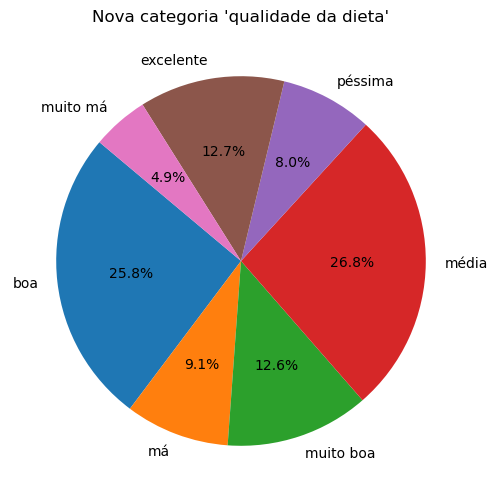

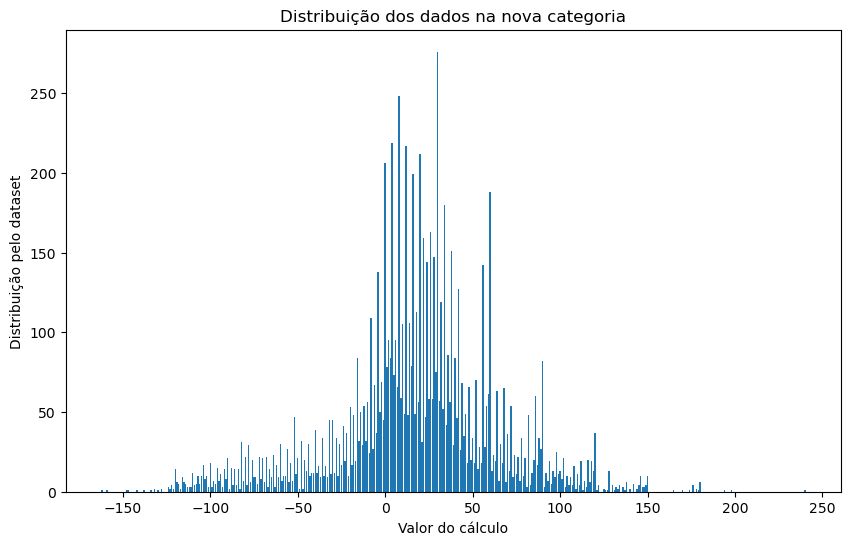

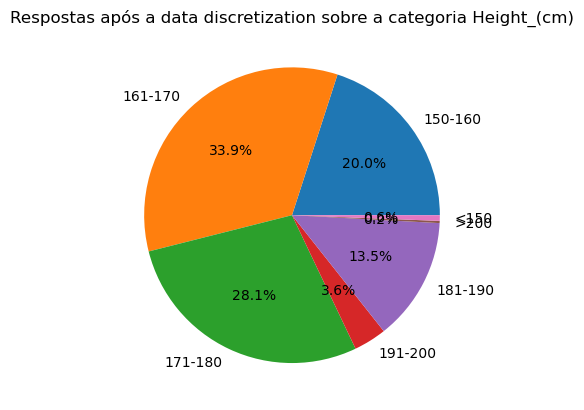

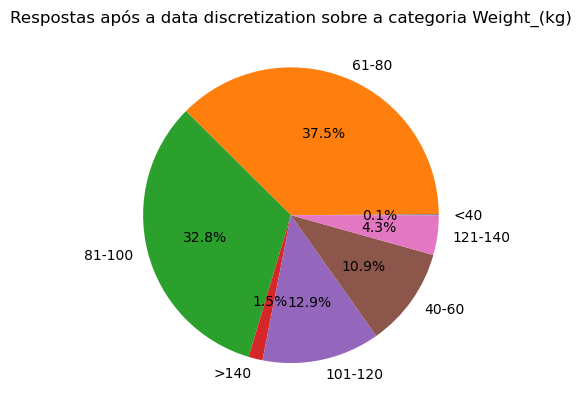

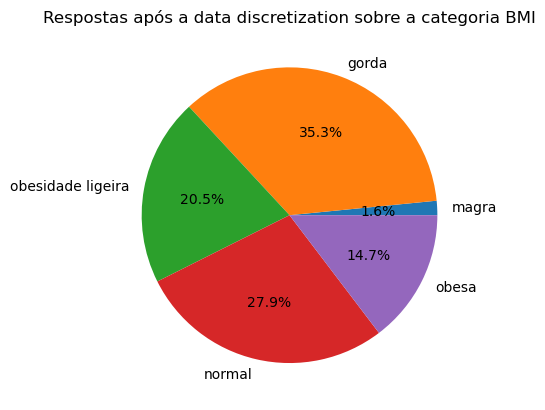

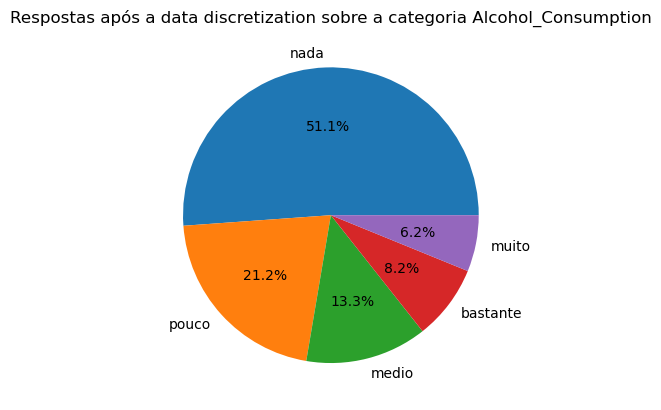

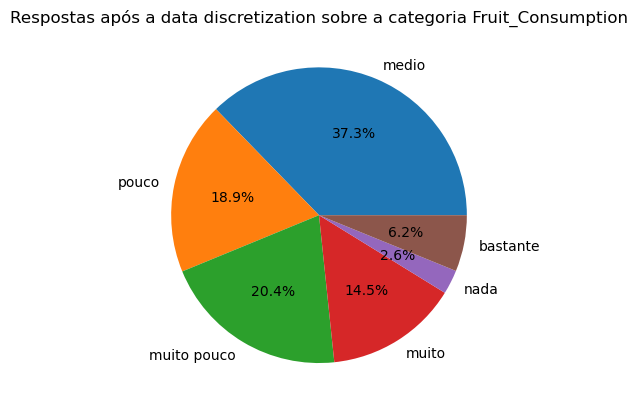

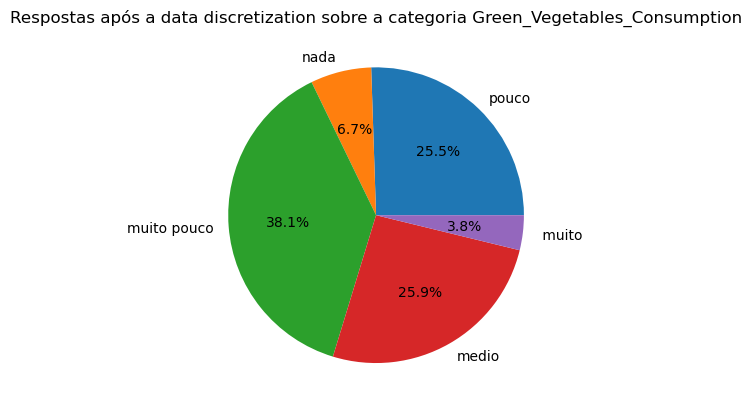

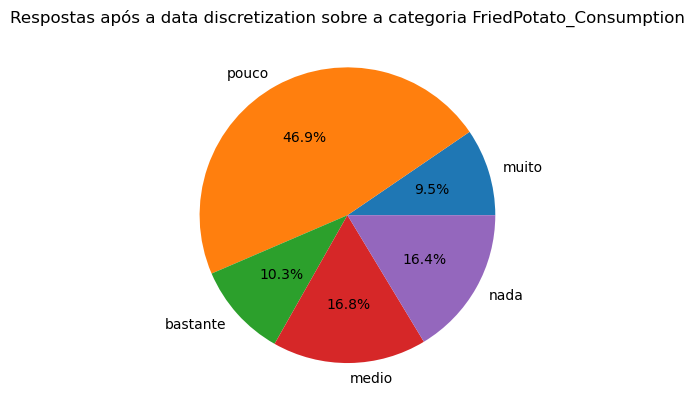

Dataset normal:
     General_Health                  Checkup Exercise Heart_Disease  \
0              Poor  Within the past 2 years       No            No   
1         Very Good     Within the past year       No           Yes   
2         Very Good     Within the past year      Yes            No   
3              Poor     Within the past year      Yes           Yes   
4              Good     Within the past year       No            No   
...             ...                      ...      ...           ...   
9260      Very Good     Within the past year      Yes            No   
9261           Good     Within the past year      Yes           Yes   
9262      Excellent  Within the past 5 years      Yes            No   
9263      Very Good     Within the past year      Yes            No   
9264           Good      5 or more years ago      Yes            No   

     Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
0             No           No         No       No       Yes 

In [192]:
# Data Reduction (Vicente) # Reduz o dataset
reduced_dataset = data_reduction(pandas_frame_dataset.copy(), True) # True para graficos para demonstracao

# Data Discretization (Vicente): Aplica discretização aos dados para categorizá-los
discretized_dataset = data_discretization(pandas_frame_dataset.copy(), True) # True para graficos para demonstracao

# Data Normalization (Jonnas)
normalized_dataset = normalize_dataset(pandas_frame_dataset.copy()) # normalisa os valores

print("Dataset normal:")
print(pandas_frame_dataset)
print("dataset normalizado:")
print(normalized_dataset)
print("Dataset com discretization:")
print(discretized_dataset)
print("Data reduction")
print(reduced_dataset)

### 4. Modeling

#### Supervised Learning

In [193]:
def decision_trees(dataset):
    # X são as features, y é o target
    X, y, _ = preprocess_dataset(dataset, debug=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Training...
    start_train_time = time.time()
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    end_train_time = time.time()

    # Testing... Predictions on testing data.
    start_test_time = time.time()
    y_pred_test = dt_model.predict(X_test)
    end_test_time = time.time()

    # Predictions on training data
    y_pred_train = dt_model.predict(X_train)

    training_time = end_train_time - start_train_time
    testing_time = end_test_time - start_test_time

    return y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time
    #return y_test, y_pred, training_time, testing_time

def k_nn(dataset):
    # X são as features, y é o target
    X, y, _ = preprocess_dataset(dataset)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalizar features, importante para garantir que as features contribuem todas de forma igual para o cálculo da distância.
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)

    # Training...
    start_train_time = time.time()
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    end_train_time = time.time()

    # Testing... Predictions on testing data.
    start_test_time = time.time()
    y_pred_test = knn_model.predict(X_test)
    end_test_time = time.time()

    # Predictions on training data
    y_pred_train = knn_model.predict(X_train)

    training_time = end_train_time - start_train_time
    testing_time = end_test_time - start_test_time

    return y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time
    #return y_test, y_pred, training_time, testing_time

def multi_layer_perceptron(dataset):
    # X são as features, y é o target
    X, y, _ = preprocess_dataset(dataset)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalizar features
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)

    # Training...
    start_train_time = time.time()
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2500, tol=1e-5, random_state=42)
    mlp_model.fit(X_train, y_train)
    end_train_time = time.time()

    # Testing... Predictions on testing data.
    start_test_time = time.time()
    y_pred_test = mlp_model.predict(X_test)
    end_test_time = time.time()

    # Predictions on training data
    y_pred_train = mlp_model.predict(X_train)

    training_time = end_train_time - start_train_time
    testing_time = end_test_time - start_test_time

    return y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time
    #return y_test, y_pred, training_time, testing_time

#### Unsupervised Learning

In [194]:
def kmeans(dataset, com_graficos):
	""" 
	Implementaçao do kmeans, pode retornar informaçoes e graficos extra para o kmeans com com_graficos = True
	"""
	# Meter o dataset para numeros
	dataset = preprocess_dataset(dataset,True)

	# KMeans
	inicio = time.time()
	kmeans = KMeans(n_clusters=6)
	kmeans.fit(dataset)
	tempo = time.time() - inicio
	cluster_labels = kmeans.labels_

	# guardar os clusters criados
	dataset_clusters = dataset.copy()
	dataset_clusters['Cluster'] = cluster_labels

	# mostrar a avaliaçaod e cada cluster da categoria 'Heart_Disease'
	cluster_predictions = dataset_clusters.groupby('Cluster')['Heart_Disease'].transform(lambda x: x.mode()[0])

	if com_graficos:

		print("Metricas do kmeans:")
		print(classification_report(dataset_clusters['Heart_Disease'], cluster_predictions))

		# Distribuiçao dos valores do dataset por cluster
		plt.figure(figsize=(10, 6))
		sns.countplot(x='Cluster', data=dataset_clusters, palette='viridis')
		plt.title("Distribuição dos clusters")
		plt.xlabel("Cluster")
		plt.ylabel("Numero de elementos")
		plt.show()

		# Percentagem de Heart Disease em cada cluster
		heart_disease_dist = dataset_clusters.groupby(['Cluster', 'Heart_Disease']).size().unstack(fill_value=0)
		heart_disease_dist = (heart_disease_dist.T / heart_disease_dist.sum(axis=1)).T * 100
		heart_disease_dist.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
		plt.title("Distribuição da categoria 'Heart Disease' pelos clusters")
		plt.xlabel("Cluster")
		plt.ylabel("Percentagem")
		plt.legend(title="Heart Disease")
		plt.show()


	return cluster_predictions, tempo


def dbscan(dataset, com_graficos):
	""" 
	Implementaçao do dbscan, pode retornar informaçoes e graficos extra para o dbscan com com_graficos = True
	"""
	# Meter o dataset para numeros
	dataset = preprocess_dataset(dataset,True)

	# DBSCAM
	inicio = time.time()
	dbscan = DBSCAN(eps=3, min_samples=15)
	dbscan.fit(dataset)
	tempo = time.time() - inicio
	labels_dbscan = dbscan.labels_

	# guardar os clusters criados
	dataset_clusters = dataset.copy()
	dataset_clusters['Cluster'] = labels_dbscan
	dataset_clusters_sem_noise = dataset_clusters[dataset_clusters['Cluster'] != -1].copy()

	# mostrar a avaliaçaod e cada cluster da categoria 'Heart_Disease' tendo em conta os clusters irrelevantes (noise points)
	cluster_predictions = dataset_clusters.groupby('Cluster')['Heart_Disease'].transform(lambda x: x.mode()[0] if len(x) > 0 else 'Unknown')

	if com_graficos:
		print(f"Numero de noise points: {np.sum(labels_dbscan == -1)}")

		print("Metricas do DBSCAN:")
		print(classification_report(dataset_clusters['Heart_Disease'], cluster_predictions))

		# Distribuiçao dos valores do dataset por cluster
		plt.figure(figsize=(10, 6))
		sns.countplot(x='Cluster', data=dataset_clusters_sem_noise, palette='viridis')
		plt.title("Distrubuição dos Clusters")
		plt.xlabel("Cluster")
		plt.ylabel("Numero de elementos")
		plt.show()

		# Percentagem de Heart Disease em cada cluster
		heart_disease = dataset_clusters_sem_noise.groupby(['Cluster', 'Heart_Disease']).size().unstack(fill_value=0)
		heart_disease = (heart_disease.T / heart_disease.sum(axis=1)).T * 100
		heart_disease.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
		plt.title("Distribuição da categoria 'Heart Disease' pelos clusters")
		plt.xlabel("Cluster")
		plt.ylabel("Percentagem")
		plt.legend(title="Heart Disease")
		plt.show()

	return cluster_predictions, tempo

def metodo_cotovelo(dataset):
	"""
	Metodo utilizado para encontrar o numero otimo de clusters no kmeans e a distancia entre clusters no dbscan

	kmeans: https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
	dbscan: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
	"""

	dataset = preprocess_dataset(dataset,True)

	# numero ideal do kmenas
	Sum_of_squared_distances = []

	for num_clusters in range(1,15): # clusters a testar
		kmeans = KMeans(n_clusters=num_clusters)
		kmeans.fit(dataset)
		Sum_of_squared_distances.append(kmeans.inertia_)

	plt.plot(range(1,15),Sum_of_squared_distances,'bx-')
	plt.xlabel("Numero de cluesters") 
	plt.ylabel("Soma das distancias")
	plt.show()
	
	# numero ideal de eps para o DBSCAN
	neighbors = NearestNeighbors(n_neighbors=15*2)
	neighbors_fit = neighbors.fit(dataset)
	distances, indices = neighbors_fit.kneighbors(dataset)
	distances = np.sort(distances, axis=0)
	distances = distances[:,1]

	plt.plot(distances)
	plt.show()

In [195]:
# mostrar como obti o numero de clusters do kmeans e eps do dbscan
# metodo_cotovelo(pandas_frame_dataset.copy())

# ignorar warnings para nao obstruirem o output
warnings.filterwarnings("ignore")

resultados_kmeans, tempo_execucao_kmeans = kmeans(pandas_frame_dataset.copy(), False) # Para mais graficos meter True
# plot_metrics(pandas_frame_dataset.copy()['Heart_Disease'] , resultados_kmeans , "KMeans" , tempo_execucao_kmeans)

resultados_dbscan, tempo_execucao_dbscan = dbscan(pandas_frame_dataset.copy(), False) # Para mais graficos meter True
# plot_metrics(pandas_frame_dataset.copy()['Heart_Disease'] , resultados_dbscan , "KMeans" , tempo_execucao_dbscan)

### 5. Evaluation

In [196]:
def plot_metrics(y_test, y_pred_test, y_train=None, y_pred_train=None, 
                 name="", training_time=None, testing_time=None, 
                 confusion_matrix_plot=True, times=True, metrics=True):
    """
    Plot metrics, confusion matrix, and training/testing times.
    Handles both training and testing metrics for overfitting detection.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Compute metrics for test set
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average="binary")
    test_recall = recall_score(y_test, y_pred_test, average="binary")
    test_f1 = f1_score(y_test, y_pred_test, average="binary")

    # Compute metrics for training set (if provided)
    if y_train is not None and y_pred_train is not None:
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train, average="binary")
        train_recall = recall_score(y_train, y_pred_train, average="binary")
        train_f1 = f1_score(y_train, y_pred_train, average="binary")
    else:
        train_accuracy = train_precision = train_recall = train_f1 = None

    # Initialize subplots
    n_plots = sum([confusion_matrix_plot, times, metrics])
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6))
    axes = axes if n_plots > 1 else [axes]

    # Confusion Matrix for Test Set
    if confusion_matrix_plot:
        conf_matrix = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                    xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
        axes[0].set_title(f"Confusion Matrix ({name})")
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")

    # Metrics Plot (Training vs. Testing)
    if metrics:
        test_values = [test_accuracy, test_precision, test_recall, test_f1]
        metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

        ax_idx = 1 if confusion_matrix_plot else 0
        bar_width = 0.35
        index = np.arange(len(metric_names))

        # Bar heights
        axes[ax_idx].bar(index, test_values, bar_width, color="blue", label="Performance in Test Data")
        if train_accuracy is not None:
            train_values = [train_accuracy, train_precision, train_recall, train_f1]
            axes[ax_idx].bar(index + bar_width, train_values, bar_width, color="orange", alpha=0.7, label="Performance in Train Data")

        # Add text labels above bars
        y_max = max(max(test_values), max(train_values if train_accuracy else [0])) * 1.2  # Dynamic space
        axes[ax_idx].set_ylim(0, y_max)
        for i, v in enumerate(test_values):
            axes[ax_idx].text(i, v + y_max * 0.02, f"{v:.2f}", ha="center", color="blue")
        if train_accuracy is not None:
            for i, v in enumerate(train_values):
                axes[ax_idx].text(i + bar_width, v + y_max * 0.02, f"{v:.2f}", ha="center", color="orange")

        axes[ax_idx].set_title(f"Metrics Comparison ({name})")
        axes[ax_idx].set_xticks(index + bar_width / 2)
        axes[ax_idx].set_xticklabels(metric_names)
        axes[ax_idx].legend()

    # Training and Testing Times
    if times:
        ax_idx = 2 if metrics and confusion_matrix_plot else 1 if metrics or confusion_matrix_plot else 0
        time_values = [training_time, testing_time]
        time_names = ["Training Time", "Testing Time"]
        
        # Plot the bar chart
        axes[ax_idx].bar(time_names, time_values, color=["red", "cyan"])
        axes[ax_idx].set_title(f"Training & Testing Times ({name})")
        
        # Adjust y-axis limits to leave space for labels
        y_max = max(time_values) * 1.2  # Add 20% padding above the tallest bar
        axes[ax_idx].set_ylim(0, y_max)
        
        # Add text labels above bars
        for i, v in enumerate(time_values):
            axes[ax_idx].text(i, v + y_max * 0.05, f"{v:.4f}s", ha="center")  # Offset text slightly above the bar

    plt.tight_layout()
    plt.show()

    # Return metrics for comparison
    return {
        "name": name,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1,
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_f1": train_f1,
    }

def compare_models(results):
    """
    Compara os modelos com base nas metricas, espera uma lista dos resultados da função plot_metrics com os nomes atribuidos
    """
    # Extract metrics and names
    names = [result['name'] for result in results]
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = {
        'Accuracy': [result['test_accuracy'] for result in results],
        'Precision': [result['test_precision'] for result in results],
        'Recall': [result['test_recall'] for result in results],
        'F1-Score': [result['test_f1'] for result in results],
    }

    # Plot the metrics comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(metrics))  # Label locations for metrics
    width = 0.2  # Bar width

    for i, name in enumerate(names):
        # Shift each bar group by its index to avoid overlap
        ax.bar(x + i * width, [metric_values[metric][i] for metric in metrics], width, label=name)

    # Format the plot
    ax.set_ylabel('Metric Value')
    ax.set_title('Comparison of Model Metrics')
    ax.set_xticks(x + width * (len(names) - 1) / 2)  # Center group of bars around the ticks
    ax.set_xticklabels(metrics)
    ax.legend(title='Models')

    # Add text labels above bars
    for i, name in enumerate(names):
        for j, metric in enumerate(metrics):
            value = metric_values[metric][i]
            ax.text(x[j] + i * width, value + 0.02, f'{value:.2f}', ha='center')

    plt.tight_layout()
    plt.show()

Encoding for 'General_Health': {'Excellent': 0, 'Fair': 1, 'Good': 2, 'Poor': 3, 'Very Good': 4}
Encoding for 'Checkup': {'5 or more years ago': 0, 'Never': 1, 'Within the past 2 years': 2, 'Within the past 5 years': 3, 'Within the past year': 4}
Encoding for 'Exercise': {'No': 0, 'Yes': 1}
Encoding for 'Heart_Disease': {'No': 0, 'Yes': 1}
Encoding for 'Skin_Cancer': {'No': 0, 'Yes': 1}
Encoding for 'Other_Cancer': {'No': 0, 'Yes': 1}
Encoding for 'Depression': {'No': 0, 'Yes': 1}
Encoding for 'Diabetes': {'No': 0, 'No, pre-diabetes or borderline diabetes': 1, 'Yes': 2, 'Yes, but female told only during pregnancy': 3}
Encoding for 'Arthritis': {'No': 0, 'Yes': 1}
Encoding for 'Sex': {'Female': 0, 'Male': 1}
Encoding for 'Age_Category': {'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80+': 12}
Encoding for 'Smoking_History': {'No': 0, 'Yes': 1}


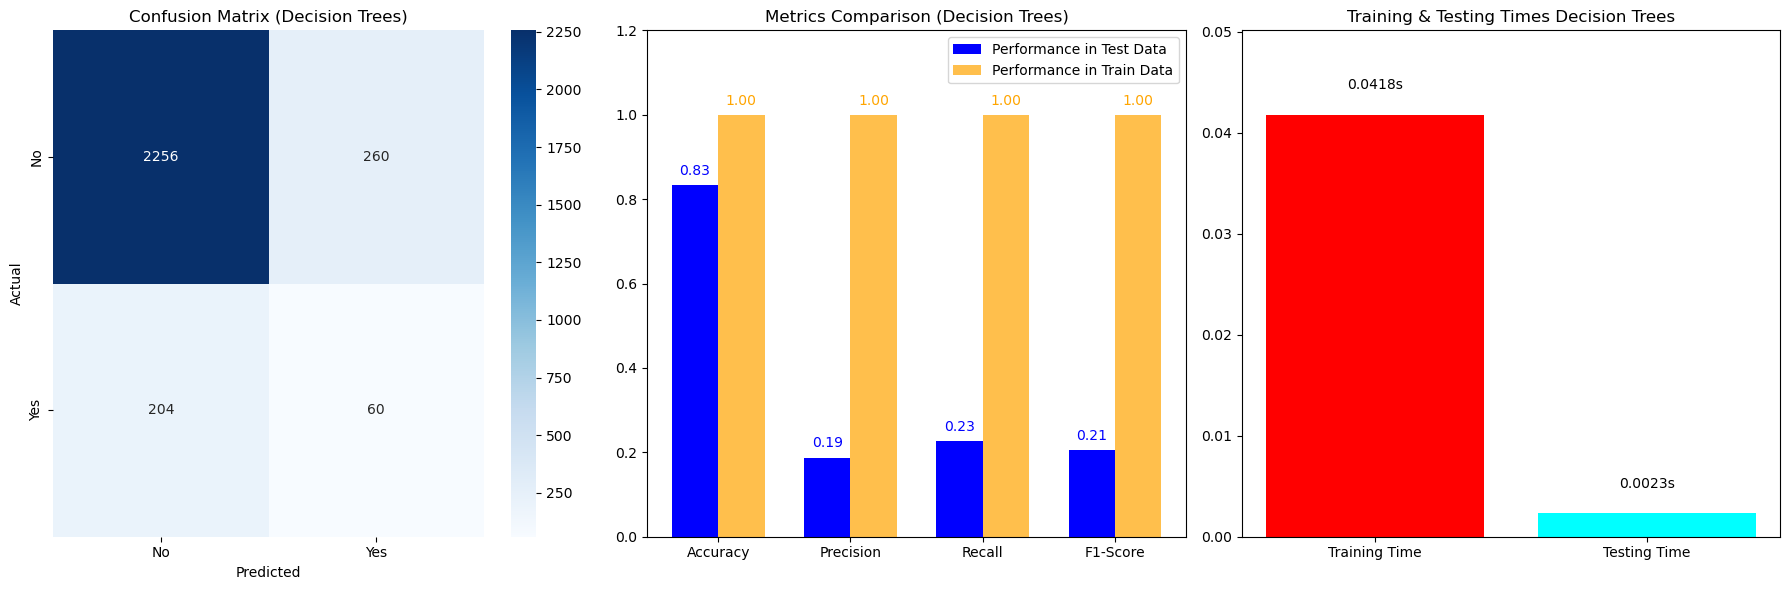

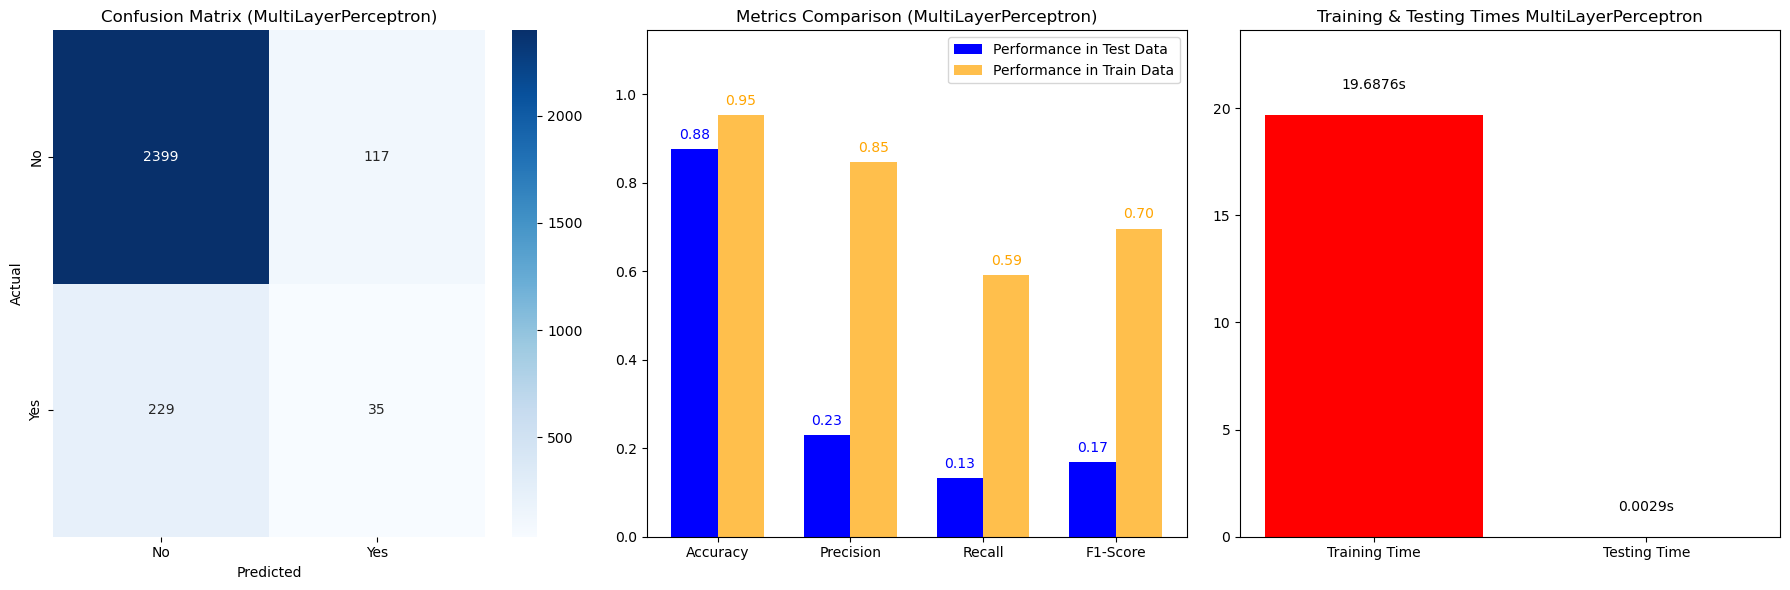

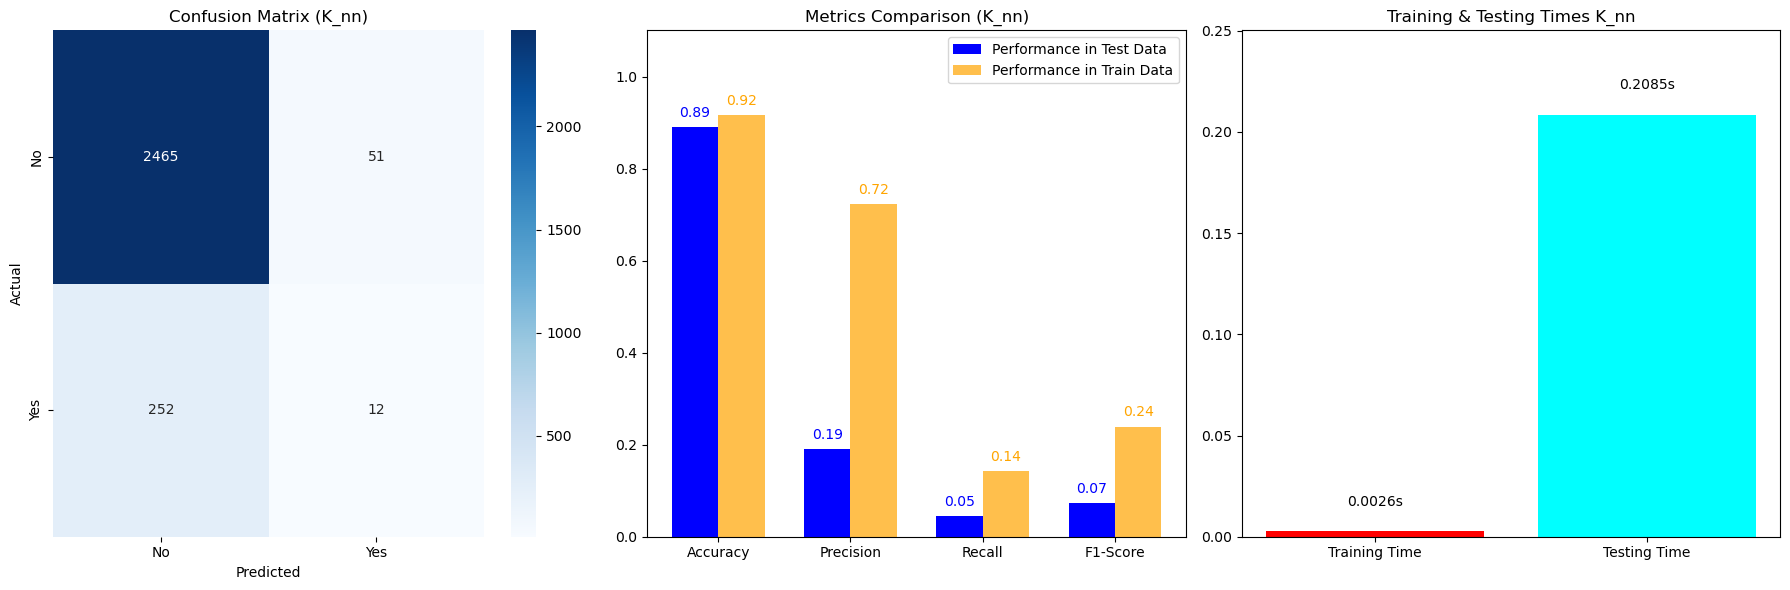

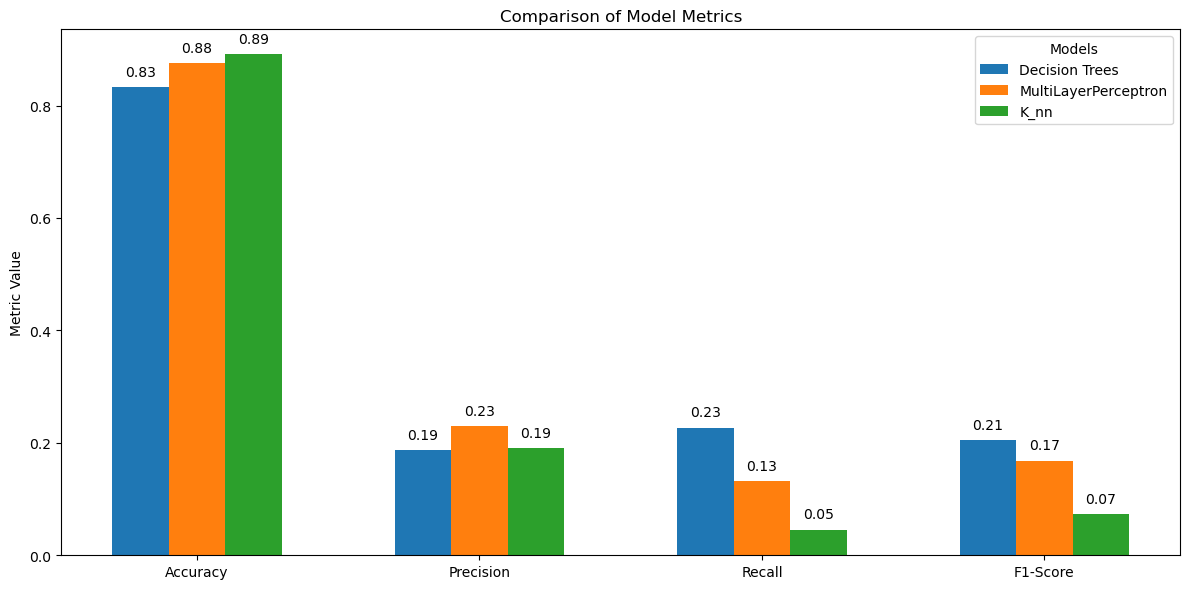

In [197]:
results_to_compare = []
normalized_dataset = normalize_dataset(pandas_frame_dataset.copy(), method='z-score') # method='min-max' or 'z-score', z-score gives better results

y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time = decision_trees(pandas_frame_dataset.copy())
metrics = plot_metrics(y_test, y_pred_test,
                       name="Decision Trees",
                       y_train=y_train, y_pred_train=y_pred_train,
                       training_time=training_time, testing_time=testing_time,
                       confusion_matrix_plot=True,
                       times=True,
                       metrics=True)
results_to_compare.append(metrics)

y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time = multi_layer_perceptron(normalized_dataset.copy()) # normalized dataset is important
metrics = plot_metrics(y_test, y_pred_test,
                        name="MultiLayerPerceptron",
                        y_train=y_train, y_pred_train=y_pred_train,
                        training_time=training_time, testing_time=testing_time,
                        confusion_matrix_plot=True,
                        times=True,
                        metrics=True)
results_to_compare.append(metrics)

y_test, y_pred_test, y_train, y_pred_train, training_time, testing_time = k_nn(normalized_dataset.copy()) # normalized dataset is important
metrics = plot_metrics(y_test, y_pred_test,
                       name="K_nn",
                       y_train=y_train, y_pred_train=y_pred_train,
                       training_time=training_time, testing_time=testing_time,
                       confusion_matrix_plot=True,
                       times=True,
                       metrics=True)
results_to_compare.append(metrics)

# Comparar as metricas dos modelos:
compare_models(results_to_compare)